In [1]:
import scSpace
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
import pandas as pd
import random
import torch
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform, pdist
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

/home/qjy/.conda/envs/scspace_new/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False

In [7]:
sc_data_dir = '~/workspace/scSpace/data/melanoma_new/data/original_data/Mel1_sc_dt.csv'
sc_meta_dir = '~/workspace/scSpace/data/melanoma_new/data/original_data/Mel1_sc_ct.csv'
st_data_dir = '~/workspace/scSpace/data/melanoma_new/data/original_data/st_data_m1_r2.csv'
st_meta_dir = '~/workspace/scSpace/data/melanoma_new/data/original_data/st_meta_m1_r2.csv'

sc_obj, st_obj = scSpace.load_data(
    sc_data_path=sc_data_dir, sc_meta_path=sc_meta_dir, 
    st_data_path=st_data_dir, st_meta_path=st_meta_dir,
    spatial_key=['xcoord','ycoord'])

sc_obj_hvg, st_obj_hvg = scSpace.preporcess(
    sc_adata=sc_obj, st_adata=st_obj, st_type='spot', n_features=2000, 
    normalize=True, select_hvg='union')

setup_seed(123)
starttime = time.time()
sc_obj_hvg, st_obj_hvg = scSpace.construct_pseudo_space(
    sc_adata=sc_obj_hvg,
    st_adata=st_obj_hvg,
    batch_size=16,
    hidden_size=128,
    activation='sigmoid',
    lr=0.001,
    epoch_num=1000,
    log_epoch=1000
)
        
endtime = time.time()
print(endtime - starttime)

Loading data...
Data have been loaded.
Data have been pre-processed.
Beginning Transfer Component Analysis...
Transfer Component Analysis done.
Beginning training encoder for source domain...


100%|███████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.83it/s]

Epoch [1000/1000]: Batch loss=7.635671615600586
Encoder for source domain training finished.
422.53371953964233


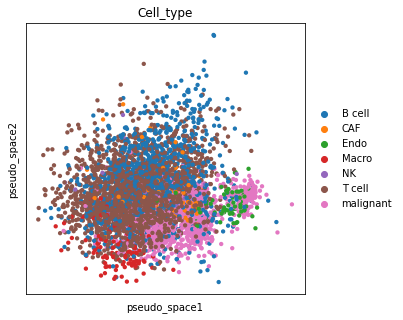

In [8]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(sc_obj_hvg, basis="pseudo_space", color="Cell_type", size=75)
plt.show()

In [13]:
tcell_adata = sc_obj_hvg[sc_obj_hvg.obs['Cell_type'].isin(['T cell'])]

tcell_adata = scSpace.spatial_cluster(
    sc_adata=tcell_adata,
    Ks=20,
    Kg=10,
    res=0.5,
    target_num=5
)
tcell_adata.obs.to_csv('~/workspace/scSpace/data/melanoma_new/result/tcell_subtype.csv')

Start at res =  0.5 step =  0.1
Res =  0.5 number of clusters =  6
Res =  0.4 number of clusters =  4
Step changed to 0.05
Res =  0.45 number of clusters =  5
Recommended res =  0.45


In [15]:
pd.DataFrame(sc_obj_hvg.obsm['pseudo_space']).to_csv('~/workspace/scSpace/data/melanoma_new/result/m1_pseudo.csv')